In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
import tensorflow as tf
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # EarlyStopping during model training
from tensorflow.keras.optimizers import Adam
import math


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/btcinusd/BTC-2019min.csv
/kaggle/input/btcinusd/BTC-Hourly.csv
/kaggle/input/btcinusd/BTC-Daily.csv
/kaggle/input/btcinusd/BTC-2020min.csv
/kaggle/input/btcinusd/BTC-2017min.csv
/kaggle/input/btcinusd/BTC-2018min.csv
/kaggle/input/btcinusd/BTC-2021min.csv
/kaggle/input/etherum-2022-minbymin/ETHUSDT_Binance_futures_2022_minute.csv
/kaggle/input/etherum/ETH-USD.csv
/kaggle/input/btcdata/BTC-USD.csv


# **Preprosessing**

In [2]:
df = pd.read_csv('../input/etherum-2022-minbymin/ETHUSDT_Binance_futures_2022_minute.csv')
# Removing all unessesary columns ( See Research )
df = df = df.drop(["Volume ETH", "unix","Volume USDT", "symbol","open","tradecount"], axis=1)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')
df.index = df.pop("date")
df

,high,low,close
date,,,
2022-01-01 00:01:00,3692.29,3681.11,3690.61
2022-01-01 00:02:00,3692.94,3685.66,3692.00
2022-01-01 00:03:00,3693.93,3688.21,3689.25
2022-01-01 00:04:00,3689.69,3686.55,3688.53
2022-01-01 00:05:00,3698.26,3685.00,3697.77
...,...,...,...
2022-09-07 00:12:00,1562.67,1561.08,1561.09
2022-09-07 00:13:00,1561.98,1560.01,1560.99
2022-09-07 00:14:00,1562.00,1560.50,1560.88


# **Standardization**

In [3]:
# Scaler for N-Dimensional Array
df_features = df
df_np = df_features.to_numpy()
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_np, (-1,1))
df_scaled[0]

array([0.93307773, 0.93242654, 0.93452141])

In [4]:
# Scaler for 1D array
df_close = pd.DataFrame(df['close'])
df_close_np = df_close.to_numpy()
to_inverse_scale = MinMaxScaler()
df_close_scale = to_inverse_scale.fit_transform(df_close_np)
df_close_scale

array([[0.93452141],
       [0.93498417],
       [0.93406864],
       ...,
       [0.22549297],
       [0.22570271],
       [0.22394822]])

# **Converting Data to 3 Dimensions **

In [5]:
x = [] # The features needed for prediction.
y = [] # The expected result.

for i in range(len(df_scaled)-7):
    x.append(df_scaled[i:i+7])

for i in range(len(df_close_scale)-1):
        y.append(df_close_scale[i][0])


# Converting to Numpy array for easier reading by the ML-Algorithm
X = np.array(x)
Y = np.array(y)




# **Splitting the Data (Train/Test)**

In [6]:
train_no = math.floor(len(X) * 0.7) # 70% for training, 30% For Testing
total_no = len(X) 
X_Train, Y_Train = X[:train_no][:train_no], Y[:train_no]
X_Test, Y_Test = X[train_no: total_no - 1], Y[train_no: total_no - 1]

In [7]:
print(X_Train.shape, Y_Train.shape)
print(X_Test.shape, Y_Test.shape)

(250998, 7, 3) (250998,)
(107570, 7, 3) (107570,)


# **Developing The Model**

In [8]:
model = Sequential()
# Three layers, Final Output is in an array of 10 predictions
model.add(LSTM(400, return_sequences=True, input_shape=(7,3)))
model.add(LSTM(350, return_sequences=True))
model.add(LSTM(300, return_sequences=True))
model.add(LSTM(250, return_sequences=True))
model.add(LSTM(200, return_sequences=True))
model.add(LSTM(150, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(20))
model.add(Dense(25))
model.add(Dense(10))
model.add(Dense(5))
model.add(Dense(1))
          

2022-11-05 19:06:56.592739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 19:06:56.593672: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 19:06:56.891394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 19:06:56.892225: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 19:06:56.893030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [9]:
model.compile(optimizer="Adam", loss='mean_squared_error') # Compling the Model

In [10]:
callback = [EarlyStopping(monitor='loss', patience=10, verbose=1, mode='min')]

In [11]:
modeled = model.fit(X_Train, Y_Train, batch_size=10000, epochs=500, callbacks=callback) # Training the model

2022-11-05 19:07:04.783190: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500


2022-11-05 19:07:14.409021: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


26/26 [==============================] - 26s 478ms/step - loss: 0.0896
Epoch 2/500
26/26 [==============================] - 13s 490ms/step - loss: 0.0305
Epoch 3/500
26/26 [==============================] - 13s 496ms/step - loss: 0.0018
Epoch 4/500
26/26 [==============================] - 13s 508ms/step - loss: 4.4299e-04
Epoch 5/500
26/26 [==============================] - 13s 518ms/step - loss: 2.1572e-04
Epoch 6/500
26/26 [==============================] - 14s 521ms/step - loss: 1.3193e-04
Epoch 7/500
26/26 [==============================] - 14s 539ms/step - loss: 8.6394e-05
Epoch 8/500
26/26 [==============================] - 14s 553ms/step - loss: 5.9872e-05
Epoch 9/500
26/26 [==============================] - 15s 559ms/step - loss: 4.2186e-05
Epoch 10/500
26/26 [==============================] - 15s 571ms/step - loss: 2.9942e-05
Epoch 11/500
26/26 [==============================] - 15s 585ms/step - loss: 2.1023e-05
Epoch 12/500
26/26 [==============================] - 15s 573ms/s

# **Testing the Model**

In [12]:
#x = X_Test.reshape(-1,1)
predictions = model.predict(X_Test)
predictions = to_inverse_scale.inverse_transform(predictions) # Reverse the standardization.
#predictions


In [13]:
# Putting the predictions in an array to convert into dataframe column later.
valid = []
for i in range(len(predictions)):
    valid.append(predictions[i][0]) # Using the final prediction in the array.
    

# **Validating the Results**

In [14]:
new_df = pd.DataFrame(df[train_no: total_no - 1])
new_df = new_df.drop(["high","low"], axis=1)
new_df['Prediction'] = valid


new_df

,close,Prediction
date,,
2022-06-24 07:19:00,1137.57,1124.407837
2022-06-24 07:20:00,1136.92,1124.847534
2022-06-24 07:21:00,1135.86,1124.111206
2022-06-24 07:22:00,1136.98,1125.168213
2022-06-24 07:23:00,1137.51,1125.983154
...,...,...
2022-09-07 00:04:00,1565.57,1552.329102
2022-09-07 00:05:00,1565.64,1552.585815
2022-09-07 00:06:00,1564.37,1552.183350


<AxesSubplot:xlabel='date'>

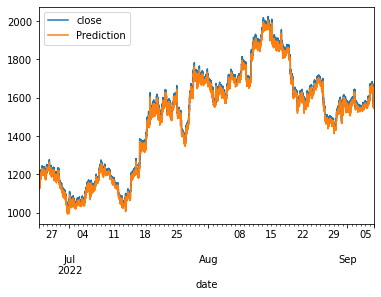

In [15]:
new_df.plot()

In [16]:
new_df.corr() # Accuracy around 99.5%

,close,Prediction
close,1.000000,0.999987
Prediction,0.999987,1.000000


In [17]:
df = pd.read_csv('../input/etherum/ETH-USD.csv')
# Removing all unessesary columns ( See Research )
df = df = df.drop(["Volume", "Adj Close","Open"], axis=1)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
df.index = df.pop("Date")
#df = df[:336]
#tests = model.predict(test)
#tests =to_inverse_scale.inverse_transform(tests)
#t = []
#for i in range(len(tests)):
    #t.append(tests[i][0])
df


,High,Low,Close
Date,,,
2021-11-05,4570.895996,4447.487305,4486.243164
2021-11-06,4530.997070,4334.973633,4521.581055
2021-11-07,4640.921875,4510.984375,4620.554688
2021-11-08,4822.363281,4619.649414,4812.087402
2021-11-09,4837.589355,4718.039063,4735.068848
...,...,...,...
2022-11-01,1606.605713,1568.098511,1579.704590
2022-11-02,1613.410645,1507.244751,1519.711792
2022-11-03,1556.759644,1517.101685,1531.541748


In [18]:
df_np = df.to_numpy()
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_np, (-1,1))
df_scaled.shape

(366, 3)

In [19]:
test = []

for i in range(len(df_scaled)-7):
    test.append(df_scaled[i:i+7])
    
#test = np.array(test)

test = np.array(test)

In [20]:
test.shape

(359, 7, 3)

In [21]:
prediction = model.predict(test)
prediction = to_inverse_scale.inverse_transform(prediction) 

predictions
valid = []
for i in range(len(prediction)):
    valid.append(prediction[i][0]) 
    

In [22]:
#new_df = pd.read_csv('/kaggle/input/btcdata/BTC-USD.csv')
new_df = df[:359]
# Removing all unessesary columns ( See Research )
#new_df['Date'] = pd.to_datetime(new_df['Date'])
#new_df = new_df.sort_values(by='Date')
#new_df.index = new_df.pop("Date")
new_df = new_df.drop([ "High", "Low"], axis=1)
new_df['Prediction'] = valid
#new_df

#valid = np.array(valid_ii)
new_df

,Close,Prediction
Date,,
2021-11-05,4486.243164,3588.592285
2021-11-06,4521.581055,3618.103271
2021-11-07,4620.554688,3687.914307
2021-11-08,4812.087402,3729.815918
2021-11-09,4735.068848,3715.347900
...,...,...
2022-10-25,1461.665405,1270.656738
2022-10-26,1566.566650,1311.087769
2022-10-27,1514.374878,1319.609009


<AxesSubplot:xlabel='Date'>

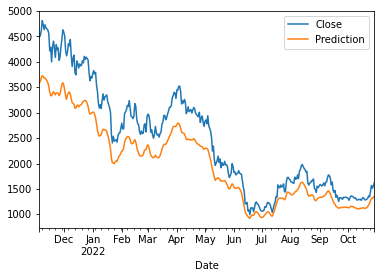

In [23]:
new_df.plot()